In [57]:
import os
import pandas as pd
import numpy as np
import re

import time
from tqdm import tqdm
import datetime as dt
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns", 500)

# Loading data from json and creating DataFrame

In [2]:
def read_data(file = 'json_file_location.json'):
    """
    Function to load single json files
    """
    
    data_frame = pd.read_json(file, 
                               orient='records', 
                               lines=True, 
                               convert_dates=True, 
                               keep_default_dates=True)
    return data_frame



def cleaning(df):
    """
    Creates a dataframe with distinct columns only and only german tweets; 
    defines a datetime index and sorts in an ascending manner; 
    also, deletes duplicates in the text column
    """
    
    
    ger_df = df.loc[:, ['created_at', 'id_str', 'full_text']][df.lang == 'de']
    ger_df = ger_df.set_index(pd.DatetimeIndex(ger_df['created_at'], inplace=True)).sort_values('created_at', ascending=True)
    
    clean_ger_df = ger_df.drop_duplicates('full_text')

    assert len(clean_ger_df) == (len(ger_df) - ger_df.duplicated('full_text').sum())
    
    return ger_df

In [3]:
def load_data(file_list):
    """
    Function that loads json files from a list of files, using the read_data function,
    and appends the resulting pandas DataFrames to each other
    """
    
    df = pd.DataFrame()
    
    for file in tqdm(file_list):
        if os.path.isfile(file):
            sub_df = cleaning(read_data(file))
        else:
            print('File {} not found'.format(file))
            continue
        if df.empty:
            df = sub_df
        else:
            df = df.append(sub_df)
            
    return df

In [93]:
read_in = True
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data.pickle'
if read_in:
    parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene']
    dates = ['08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09', '08-10', '08-11']
    data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        data = pickle.load(fid)
        print('data loaded')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading: ['08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09', '08-10', '08-11']


  0%|          | 0/10 [00:00<?, ?it/s]

AfD loaded


  0%|          | 0/10 [00:00<?, ?it/s]

SPD loaded


  0%|          | 0/10 [00:00<?, ?it/s]

CDU loaded


  0%|          | 0/10 [00:00<?, ?it/s]

CSU loaded


  0%|          | 0/10 [00:00<?, ?it/s]

FDP loaded


  0%|          | 0/10 [00:00<?, ?it/s]

LINKE loaded


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Gruene loaded
Done


In [94]:
for party in parties:
    print(party, data[party].shape)

AfD (183192, 3)
SPD (43100, 3)
CDU (51427, 3)
CSU (36912, 3)
FDP (20012, 3)
LINKE (35027, 3)
Gruene (28260, 3)


In [92]:
for party in parties:
    tweets = data[party].groupby('id_str').count()
    print(party, tweets[tweets["full_text"] < 1])

AfD Empty DataFrame
Columns: [created_at, full_text]
Index: []
SPD Empty DataFrame
Columns: [created_at, full_text]
Index: []
CDU Empty DataFrame
Columns: [created_at, full_text]
Index: []
CSU Empty DataFrame
Columns: [created_at, full_text]
Index: []
FDP Empty DataFrame
Columns: [created_at, full_text]
Index: []
LINKE Empty DataFrame
Columns: [created_at, full_text]
Index: []
Gruene Empty DataFrame
Columns: [created_at, full_text]
Index: []


# Quick excursion: Time series of tweets per minute

Count all tweets per timeframe and plot the tweetcount against time

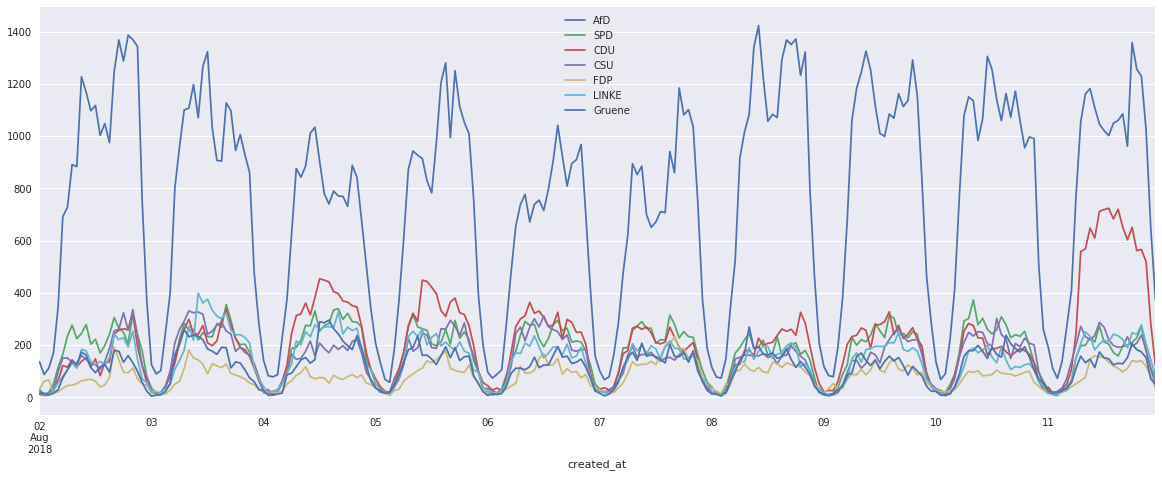

In [95]:
plt.figure(figsize=(20, 7.5))
ax = plt.axes()
for party in parties:
    data[party].loc[:, 'full_text'].resample('h').count().plot(ax=ax, label=party)
plt.legend()
# ax.grid(axis='both')
plt.show()

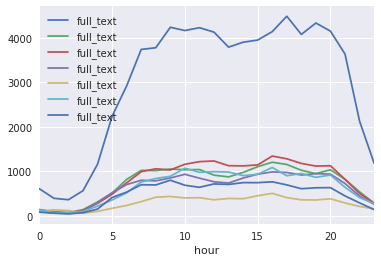

In [80]:
f, ax = plt.subplots(1, 1)
for party in parties:
    foo = pd.DataFrame(data[party].loc[:, 'full_text'].resample('h').count())
    foo['hour'] = foo.index.hour
    foo.groupby('hour').agg(sum).plot(ax = ax, label = party)    
    plt.legend()

In [96]:
def plot_tweetcount(df_list):
    """
    Interactive plotly plot that shows exactly the same data as the previous plot but is interactive.
    """
    
#     define color for the respective party !sequence matters!
    party_colors = [['AfD', 'rgb(26, 124, 199)'],
                    ['SPD', 'rgb(210, 0, 0)'], 
                    ['CDU', 'rgb(0, 29, 77)'], 
                    ['CSU', 'rgb(26, 117, 255)'], 
                    ['LINKE', 'rgb(204, 0, 102)'], 
                    ['FDP', 'rgb(255, 204, 0)'], 
                    ['Gruene', 'rgb(0, 204, 0)']]
    
    traces = []

   
    for party, color in party_colors:
#         define the number of tweets per hour
        df = df_list[party]
        tweetcount = pd.DataFrame(df.loc[:, 'full_text'].
                                  resample('h').
                                  count())
#     define the traces for the plotly plot
        trace = go.Scatter(y = tweetcount.loc[:, 'full_text'],
                           x = tweetcount.index,
                           line = {'color': color},
                           name = party)
        traces.append(trace)
        
    
    layout = go.Layout(title='Party tweet-count per hour',
                       yaxis = dict(title='Tweets per hour'),
                       xaxis = dict(title='Time'))
    
    hourly_tweetcount = go.Figure(data=traces, layout=layout)
    py.offline.iplot(hourly_tweetcount)

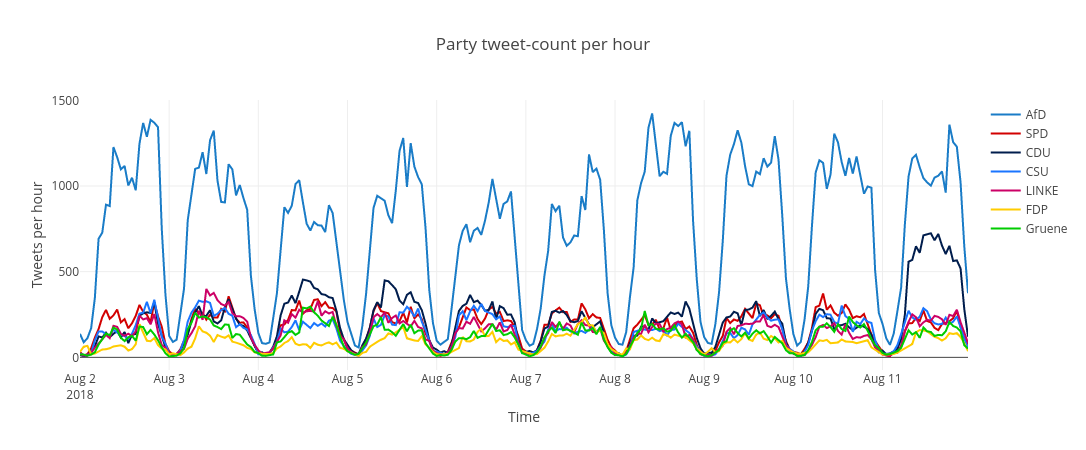

In [97]:
plot_tweetcount(data)

# Feature extraction and first clustering - 'quick and dirty'
1. Vectorize the raw tweets
2. Clustering
3. Reduce the dimension (PCA)

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [100]:
vectorizer  = CountVectorizer()
df = data["AfD"]
text = (df.loc[:, 'full_text']).tolist()
X = vectorizer.fit_transform(text)

In [101]:
X[0]

<1x105326 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [103]:
km = KMeans(n_clusters=3, # number of desired clusters
            random_state=123, 
            n_init = 10, # run algorithm 10 times independently with different random centroids to choose the final model as the one with lowest sse
            init='random', 
            max_iter=300, # max number of iterations per single run
            tol=1e-04 # controls tolerance with regard to the changes in the within-cluster sse to declare convergence
            ).fit(X)

In [ ]:
y_km = km.fit_predict(X)

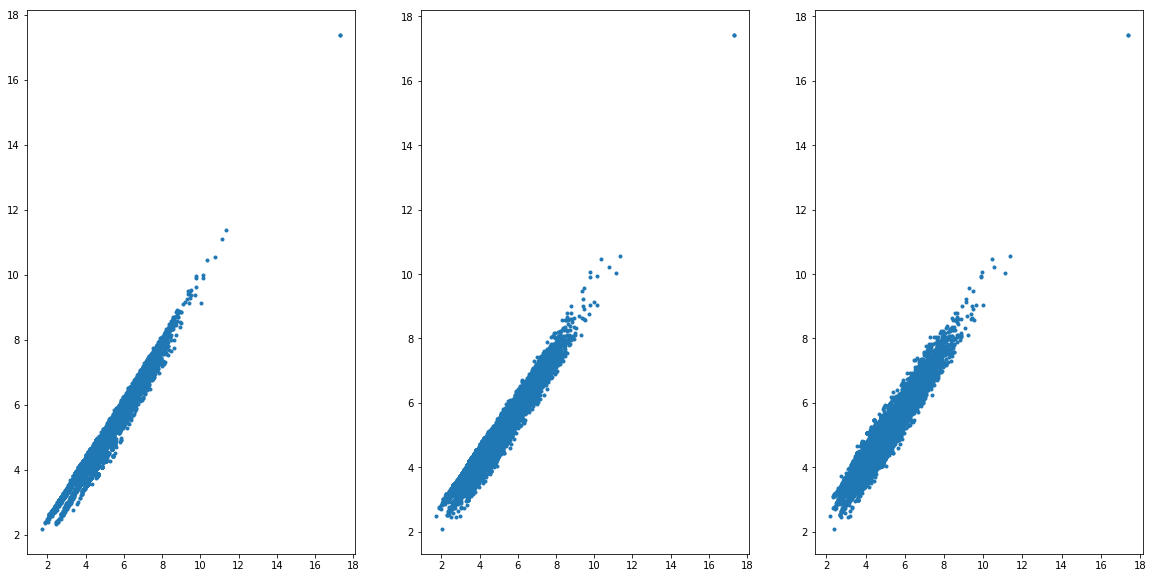

In [49]:
f, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].plot(y[:, 0], y[:, 1], ".")
ax[1].plot(y[:, 0], y[:, 2], ".")
ax[2].plot(y[:, 1], y[:, 2], ".")
plt.show()

In [50]:
foo = np.argmin(y, axis=1)

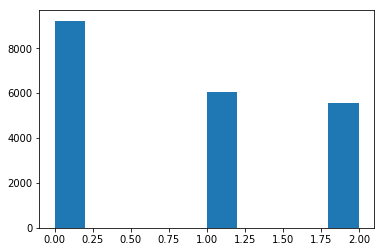

In [51]:
plt.hist(foo)
plt.show()

# Extract hashtags and party mentions

In [ ]:
text_cleaner = lambda x: " ".join(re.findall(r"[A-Za-z0-9üäöÜÄÖß#@ ]*", x))    

In [ ]:
clean_df_AFD['clean_text'] = clean_df_AFD['text'].apply(text_cleaner)

clean_df_AFD.info()
clean_df_AFD['clean_text'].astype('str')

In [ ]:
tag_finder = lambda x: re.findall(r"#(\w+)", x)
tag_remover = lambda x: re.sub("#(\w+)", '', x)

In [ ]:
clean_df_AFD['tags'] = clean_df_AFD['text'].apply(tag_finder)
clean_df_AFD['clean_text'] = clean_df_AFD['text'].apply(text_cleaner).apply(tag_remover)

In [ ]:
clean_df_AFD.head(5) #e.g. afrikanischen - look at this again!

In [ ]:
parties = ['CDU', 'CSU', 'afd', 'SPD', 'Grüne', 'Linke', 'FDP', 'Gruene'] 
            
party_finder = lambda x: re.findall((parties[2]), x, re.IGNORECASE) # does not yet work as planned

In [ ]:
clean_df_AFD['parties'] = clean_df_AFD['clean_text'].apply(party_finder)

In [ ]:
clean_df_AFD.head(5)